In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split   
from sklearn.model_selection import cross_val_score    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Data

In [2]:
data = pd.read_csv("../det_confidence_fit_df.csv")

In [3]:
data[data["gt"]==0].head()

,data,timestamp,cell,edge,mat_value,delta_mat,slope_mat,r2_mat,th,gt
0,3m_1_lying,1637714841813,"(0, 0)",1,6.44068,-1.14407,0.56183,0.42774,0.779405,0
1,3m_1_lying,1637714841813,"(0, 1)",1,6.86441,-1.22881,0.28078,0.08899,0.779405,0
2,3m_1_lying,1637714841813,"(0, 2)",1,6.44068,-0.80508,0.06666,0.00473,0.779405,0
3,3m_1_lying,1637714841813,"(0, 3)",1,6.86441,-1.65254,0.63198,0.40518,0.779405,0
4,3m_1_lying,1637714841813,"(0, 4)",1,6.01695,-1.56780,0.60007,0.32396,0.779405,0


In [4]:
data[data["gt"]==1].head()

,data,timestamp,cell,edge,mat_value,delta_mat,slope_mat,r2_mat,th,gt
28,3m_1_lying,1637714841813,"(4, 4)",0,11.10169,3.89831,-2.07597,0.54290,0.779405,1
69,3m_1_lying,1637714842211,"(4, 4)",0,11.52542,4.32203,-1.84746,0.55511,0.815439,1
110,3m_1_lying,1637714842610,"(4, 4)",0,10.67797,3.47458,-1.60775,0.56399,0.851278,1
151,3m_1_lying,1637714843408,"(4, 4)",0,10.67797,3.47458,-1.85095,0.54462,0.885943,1
192,3m_1_lying,1637714843814,"(4, 4)",0,10.25424,3.05085,-1.71641,0.49328,0.850800,1


# Logistic Regression

In [5]:
d = data.copy()
d["slope_edge"] = d["edge"] * d["slope_mat"]
d["r2_edge"] = d["edge"] * d["r2_mat"]
d = d.rename(columns={"slope_mat": "slope", "r2_mat": "r2"})
Y = d['gt'] 
X = d.drop(columns=["gt", "data", "timestamp", "cell", "mat_value", "delta_mat", "th"]) 

X = sm.add_constant(X)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

## Check Performance

In [7]:
model = sm.Logit(Y_train, X_train)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.040156
         Iterations 11


In [8]:
Y_train_pred = result.predict(X_train)  
Y_test_pred = result.predict(X_test)
Y_train_pred_binary = (Y_train_pred > 0.5).astype(int) 
Y_test_pred_binary = (Y_test_pred > 0.5).astype(int) 


train_acc = accuracy_score(Y_train, Y_train_pred_binary)
test_acc = accuracy_score(Y_test, Y_test_pred_binary)

train_precision = precision_score(Y_train, Y_train_pred_binary)
test_precision = precision_score(Y_test, Y_test_pred_binary)

train_recall = recall_score(Y_train, Y_train_pred_binary)
test_recall = recall_score(Y_test, Y_test_pred_binary)

train_f1 = f1_score(Y_train, Y_train_pred_binary)
test_f1 = f1_score(Y_test, Y_test_pred_binary)

print("Train: accuracy={:4.4f}, precision={:4.4f}, recall={:4.4f}, f1={:4.4f}".format(train_acc, train_precision, train_recall, train_f1))
print("Test: accuracy={:4.4f}, precision={:4.4f}, recall={:4.4f}, f1={:4.4f}".format(test_acc, test_precision, test_recall, test_f1))

Train: accuracy=0.9845, precision=0.8623, recall=0.7638, f1=0.8100
Test: accuracy=0.9850, precision=0.8602, recall=0.7620, f1=0.8081


## Fit Overrall Model

The following results are the source of calibrated parameters here: https://github.com/butlrtechnologies/algo/blob/dev/headcount-zero-event-confidence/butlr-algo-main/butlr_algo_main/util.py#L152-L159

In [9]:
model_lr = sm.Logit(Y, X)
result_lr = model_lr.fit()

print(result_lr.summary())

Optimization terminated successfully.
         Current function value: 0.040076
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                     gt   No. Observations:               160877
Model:                          Logit   Df Residuals:                   160871
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Jun 2024   Pseudo R-squ.:                  0.7733
Time:                        00:19:35   Log-Likelihood:                -6447.4
converged:                       True   LL-Null:                       -28438.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6427      0.056    -82.502      0.000      -4.753      -4.532
edge          -1.5991      0

## Confidence Distribution

Text(0.5, 1.0, 'Confidence Distribution for GT=1 (Detection)')

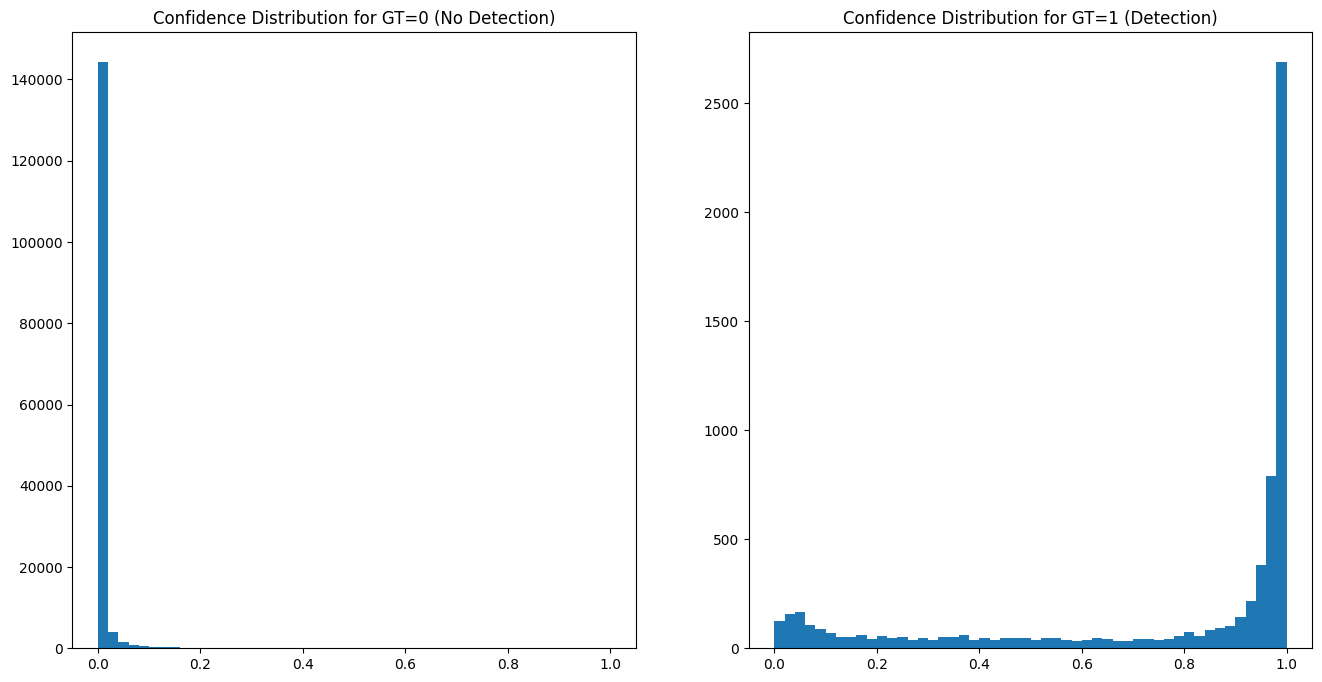

In [10]:
confidence = result_lr.predict(X).values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_ = ax1.hist(confidence[Y==0], bins=50)
_ = ax2.hist(confidence[Y==1], bins=50)

ax1.set_title("Confidence Distribution for GT=0 (No Detection)")
ax2.set_title("Confidence Distribution for GT=1 (Detection)")

# Random Forest

In [11]:
num_trees = 100

In [12]:
rfModel = RandomForestClassifier(n_estimators=num_trees,
                                 random_state=0)

randomGrid = {'max_depth': range(5,50,5), 'min_samples_leaf': range(1,101,10)}

predictor_random_search = RandomizedSearchCV(estimator=rfModel, param_distributions = randomGrid,
                                             n_iter=64, cv=4, verbose=1, random_state=0, 
                                             refit=True, scoring='accuracy', n_jobs=-1)

predictor_random_search.fit(X_train, Y_train)
winner = predictor_random_search.best_estimator_
bestParams = predictor_random_search.best_params_
print("bestParams:\n", bestParams)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
bestParams:
 {'min_samples_leaf': 11, 'max_depth': 10}


In [13]:
Y_train_pred = winner.predict(X_train)  
Y_test_pred = winner.predict(X_test)

train_acc = accuracy_score(Y_train, Y_train_pred)
test_acc = accuracy_score(Y_test, Y_test_pred)

train_precision = precision_score(Y_train, Y_train_pred)
test_precision = precision_score(Y_test, Y_test_pred)

train_recall = recall_score(Y_train, Y_train_pred)
test_recall = recall_score(Y_test, Y_test_pred)

train_f1 = f1_score(Y_train, Y_train_pred)
test_f1 = f1_score(Y_test, Y_test_pred)

print("Train: accuracy={:4.4f}, precision={:4.4f}, recall={:4.4f}, f1={:4.4f}".format(train_acc, train_precision, train_recall, train_f1))
print("Test: accuracy={:4.4f}, precision={:4.4f}, recall={:4.4f}, f1={:4.4f}".format(test_acc, test_precision, test_recall, test_f1))

Train: accuracy=0.9889, precision=0.9116, recall=0.8222, f1=0.8646
Test: accuracy=0.9884, precision=0.9041, recall=0.8062, f1=0.8524


## Fit Overall Model

In [14]:
X = X.drop(columns=["const"])

In [15]:
rfModel = RandomForestClassifier(n_estimators=num_trees,
                                 max_depth=bestParams["max_depth"],
                                 min_samples_leaf=bestParams["min_samples_leaf"],
                                 random_state=0)
rfModel.fit(X, Y)

RandomForestClassifier(max_depth=10, min_samples_leaf=11, random_state=0)

In [16]:
importance = {varname: round(importance, 3) for varname, importance in zip(rfModel.feature_names_in_, rfModel.feature_importances_)}
print('\nFeature Importances：\n\n{}\n'.format(importance))


Feature Importances：

{'edge': 0.021, 'slope': 0.626, 'r2': 0.252, 'slope_edge': 0.075, 'r2_edge': 0.026}



## Confidence Distribution

Text(0.5, 1.0, 'Confidence Distribution for GT=1 (Detection)')

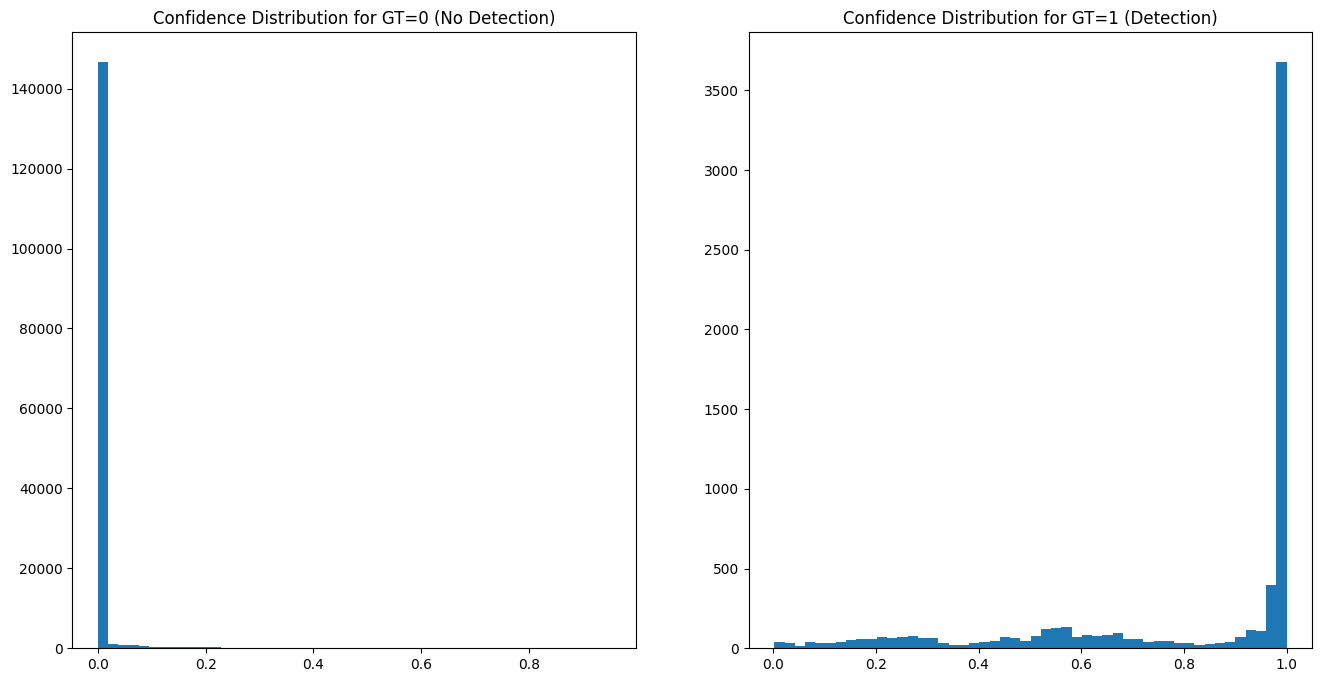

In [17]:
confidence = rfModel.predict_proba(X)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_ = ax1.hist(confidence[Y==0], bins=50)
_ = ax2.hist(confidence[Y==1], bins=50)

ax1.set_title("Confidence Distribution for GT=0 (No Detection)")
ax2.set_title("Confidence Distribution for GT=1 (Detection)")

# GBDT

In [18]:
gbdtModel = GradientBoostingClassifier(n_estimators=num_trees,
                                       random_state=0)

randomGrid = {'learning_rate': [10**x for x in range(1, -6, -1)], 'min_samples_leaf': range(1,101,10), 'max_depth': range(5,50,5)}

predictor_random_search = RandomizedSearchCV(estimator=gbdtModel, param_distributions=randomGrid,
                                             n_iter=128, cv=4, verbose=1, random_state=0, 
                                             refit=True, scoring='accuracy', n_jobs=-1)

predictor_random_search.fit(X_train, Y_train)
winner = predictor_random_search.best_estimator_
bestParams = predictor_random_search.best_params_
print("bestParams:\n", bestParams)

Fitting 4 folds for each of 128 candidates, totalling 512 fits
bestParams:
 {'min_samples_leaf': 91, 'max_depth': 25, 'learning_rate': 0.1}


In [19]:
Y_train_pred = winner.predict(X_train)  
Y_test_pred = winner.predict(X_test)

train_acc = accuracy_score(Y_train, Y_train_pred)
test_acc = accuracy_score(Y_test, Y_test_pred)

train_precision = precision_score(Y_train, Y_train_pred)
test_precision = precision_score(Y_test, Y_test_pred)

train_recall = recall_score(Y_train, Y_train_pred)
test_recall = recall_score(Y_test, Y_test_pred)

train_f1 = f1_score(Y_train, Y_train_pred)
test_f1 = f1_score(Y_test, Y_test_pred)

print("Train: accuracy={:4.4f}, precision={:4.4f}, recall={:4.4f}, f1={:4.4f}".format(train_acc, train_precision, train_recall, train_f1))
print("Test: accuracy={:4.4f}, precision={:4.4f}, recall={:4.4f}, f1={:4.4f}".format(test_acc, test_precision, test_recall, test_f1))

Train: accuracy=0.9902, precision=0.9240, recall=0.8437, f1=0.8820
Test: accuracy=0.9878, precision=0.8904, recall=0.8062, f1=0.8462


In [20]:
gbdtModel = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=bestParams["max_depth"],
                                       min_samples_leaf=bestParams["min_samples_leaf"],
                                       learning_rate=bestParams["learning_rate"],
                                       random_state=0)
gbdtModel.fit(X, Y)

GradientBoostingClassifier(max_depth=25, min_samples_leaf=91, random_state=0)

In [21]:
importance = {varname: round(importance, 3) for varname, importance in zip(gbdtModel.feature_names_in_, gbdtModel.feature_importances_)}
print('\nFeature Importances：\n\n{}\n'.format(importance))


Feature Importances：

{'edge': 0.0, 'slope': 0.841, 'r2': 0.131, 'slope_edge': 0.015, 'r2_edge': 0.012}



Text(0.5, 1.0, 'Confidence Distribution for GT=1 (Detection)')

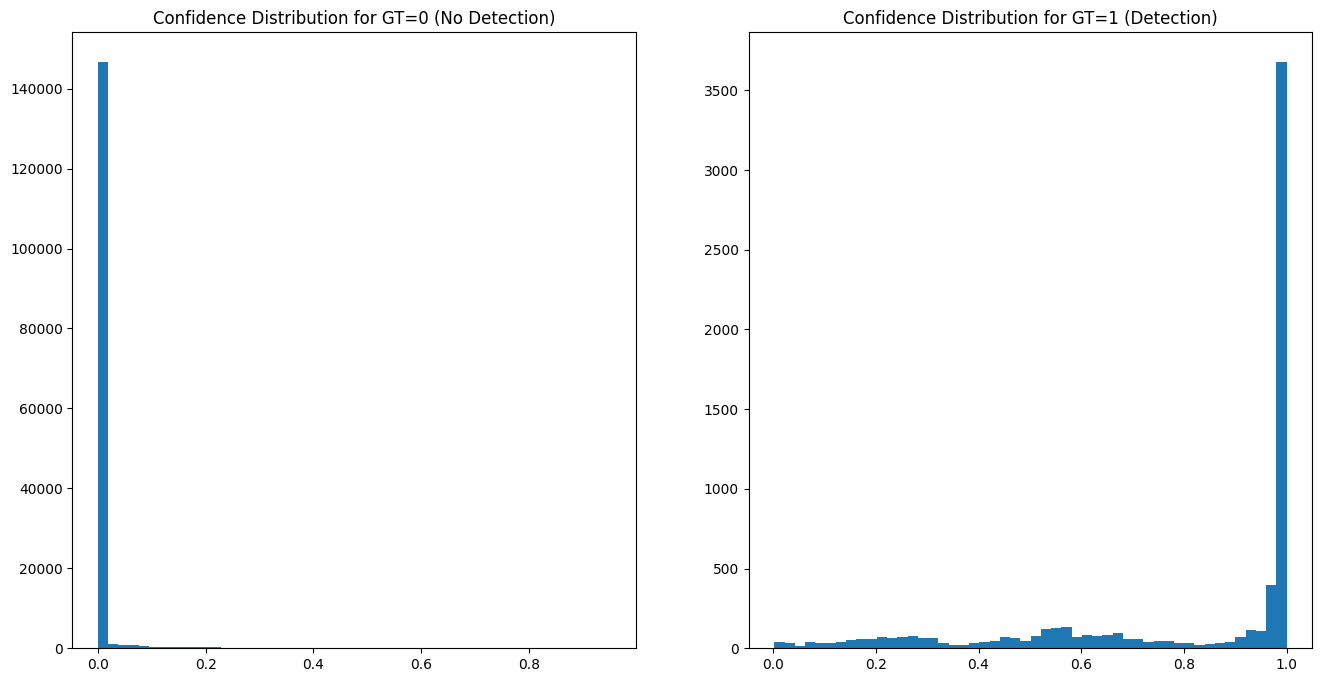

In [22]:
confidence = rfModel.predict_proba(X)[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_ = ax1.hist(confidence[Y==0], bins=50)
_ = ax2.hist(confidence[Y==1], bins=50)

ax1.set_title("Confidence Distribution for GT=0 (No Detection)")
ax2.set_title("Confidence Distribution for GT=1 (Detection)")